In [ ]:
import tensorflow as tf
import keras
import math
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, LeakyReLU, Dense
import numpy as np
import time
import argparse
!pip install livelossplot --quiet
%matplotlib inline

from time import sleep
import numpy as np

from livelossplot import PlotLosses
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pylab  as plt
from mpl_toolkits.mplot3d import Axes3D

def rand_rotation_matrix(deflection=1.0, seed=None):
    '''Creates a random rotation matrix.
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, completely random
    rotation. Small deflection => small perturbation.
    DOI: http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
         http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
    '''
    if seed is not None:
        np.random.seed(seed)

    randnums = np.random.uniform(size=(3,))

    theta, phi, z = randnums

    theta = theta * 2.0 * deflection * np.pi    # Rotation about the pole (Z).
    phi = phi * 2.0 * np.pi     # For direction of pole deflection.
    z = z * 2.0 * deflection    # For magnitude of pole deflection.

    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.

    r = np.sqrt(z)
    V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z))

    st = np.sin(theta)
    ct = np.cos(theta)

    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))

    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


def iterate_in_chunks(l, n):
    '''Yield successive 'n'-sized chunks from iterable 'l'.
    Note: last chunk will be smaller than l if n doesn't divide l perfectly.
    '''
    for i in range(0, len(l), n):
        yield l[i:i + n]

        
def add_gaussian_noise_to_pcloud(pcloud, mu=0, sigma=1):
    gnoise = np.random.normal(mu, sigma, pcloud.shape[0])
    gnoise = np.tile(gnoise, (3, 1)).T
    pcloud += gnoise
    return pcloud


def apply_augmentations(batch, conf):
    if conf.gauss_augment is not None or conf.z_rotate:
        batch = batch.copy()

    if conf.gauss_augment is not None:
        mu = conf.gauss_augment['mu']
        sigma = conf.gauss_augment['sigma']
        batch += np.random.normal(mu, sigma, batch.shape)

    if conf.z_rotate:
        r_rotation = rand_rotation_matrix()
        r_rotation[0, 2] = 0
        r_rotation[2, 0] = 0
        r_rotation[1, 2] = 0
        r_rotation[2, 1] = 0
        r_rotation[2, 2] = 1
        batch = batch.dot(r_rotation)
    return batch


def unit_cube_grid_point_cloud(resolution, clip_sphere=False):
    '''Returns the center coordinates of each cell of a 3D grid with resolution^3 cells,
    that is placed in the unit-cube.
    If clip_sphere it True it drops the "corner" cells that lie outside the unit-sphere.
    '''
    grid = np.ndarray((resolution, resolution, resolution, 3), np.float32)
    spacing = 1.0 / float(resolution - 1)
    for i in range(resolution):
        for j in range(resolution):
            for k in range(resolution):
                grid[i, j, k, 0] = i * spacing - 0.5
                grid[i, j, k, 1] = j * spacing - 0.5
                grid[i, j, k, 2] = k * spacing - 0.5

    if clip_sphere:
        grid = grid.reshape(-1, 3)
        grid = grid[norm(grid, axis=1) <= 0.5]

    return grid, spacing

def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10, azim=240, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

import tensorflow as tf
import numpy as np
import warnings

from scipy.stats import entropy

try:
    from sklearn.neighbors import NearestNeighbors
except:
    print ('Sklearn module not installed (JSD metric will not work).')

try:    
    from .. external.structural_losses.tf_nndistance import nn_distance
    from .. external.structural_losses.tf_approxmatch import approx_match, match_cost
except:
    print('External Losses (Chamfer-EMD) cannot be loaded. Please install them first.')

def jsd_between_point_cloud_sets(sample_pcs, ref_pcs, resolution=28):
    '''Computes the JSD between two sets of point-clouds, as introduced in the paper ```Learning Representations And Generative Models For 3D Point Clouds```.    
    Args:
        sample_pcs: (np.ndarray S1xR2x3) S1 point-clouds, each of R1 points.
        ref_pcs: (np.ndarray S2xR2x3) S2 point-clouds, each of R2 points.
        resolution: (int) grid-resolution. Affects granularity of measurements.
    '''   
    in_unit_sphere = True
    sample_grid_var = entropy_of_occupancy_grid(sample_pcs, resolution, in_unit_sphere)[1]
    ref_grid_var = entropy_of_occupancy_grid(ref_pcs, resolution, in_unit_sphere)[1]
    return jensen_shannon_divergence(sample_grid_var, ref_grid_var)
    
def entropy_of_occupancy_grid(pclouds, grid_resolution, in_sphere=False):
    '''Given a collection of point-clouds, estimate the entropy of the random variables
    corresponding to occupancy-grid activation patterns.
    Inputs:
        pclouds: (numpy array) #point-clouds x points per point-cloud x 3
        grid_resolution (int) size of occupancy grid that will be used.
    '''
    epsilon = 10e-4
    bound = 0.5 + epsilon
    if abs(np.max(pclouds)) > bound or abs(np.min(pclouds)) > bound:
        warnings.warn('Point-clouds are not in unit cube.')

    if in_sphere and np.max(np.sqrt(np.sum(pclouds ** 2, axis=2))) > bound:
        warnings.warn('Point-clouds are not in unit sphere.')

    grid_coordinates, _ = unit_cube_grid_point_cloud(grid_resolution, in_sphere)
    grid_coordinates = grid_coordinates.reshape(-1, 3)
    grid_counters = np.zeros(len(grid_coordinates))
    grid_bernoulli_rvars = np.zeros(len(grid_coordinates))
    nn = NearestNeighbors(n_neighbors=1).fit(grid_coordinates)

    for pc in pclouds:
        _, indices = nn.kneighbors(pc)
        indices = np.squeeze(indices)
        for i in indices:
            grid_counters[i] += 1
        indices = np.unique(indices)
        for i in indices:
            grid_bernoulli_rvars[i] += 1

    acc_entropy = 0.0
    n = float(len(pclouds))
    for g in grid_bernoulli_rvars:
        p = 0.0
        if g > 0:
            p = float(g) / n
            acc_entropy += entropy([p, 1.0 - p])

    return acc_entropy / len(grid_counters), grid_counters


def jensen_shannon_divergence(P, Q):
    if np.any(P < 0) or np.any(Q < 0):
        raise ValueError('Negative values.')
    if len(P) != len(Q):
        raise ValueError('Non equal size.')

    P_ = P / np.sum(P)      # Ensure probabilities.
    Q_ = Q / np.sum(Q)

    e1 = entropy(P_, base=2)
    e2 = entropy(Q_, base=2)
    e_sum = entropy((P_ + Q_) / 2.0, base=2)
    res = e_sum - ((e1 + e2) / 2.0)

    res2 = _jsdiv(P_, Q_)

    if not np.allclose(res, res2, atol=10e-5, rtol=0):
        warnings.warn('Numerical values of two JSD methods don\'t agree.')

    return res
    
def _jsdiv(P, Q):
    '''another way of computing JSD'''
    def _kldiv(A, B):
        a = A.copy()
        b = B.copy()
        idx = np.logical_and(a > 0, b > 0)
        a = a[idx]
        b = b[idx]
        return np.sum([v for v in a * np.log2(a / b)])

    P_ = P / np.sum(P)
    Q_ = Q / np.sum(Q)

    M = 0.5 * (P_ + Q_)

    return 0.5 * (_kldiv(P_, M) + _kldiv(Q_, M))



In [ ]:
class Arguments:
  def __init__(self):
    self._parser = argparse.ArgumentParser(description='Arguments for TreeGAN.')

    # Datatset arguements
    self._parser.add_argument('--batch_size', type=int, default=1, help='Integer value for batch size.')
    self._parser.add_argument('--point_num', type=int, default=3072, help='Integer value for number of points.')
    self._parser.add_argument('--latent_dim', type=int, default=96, help='Integer value for latent vector dimension')
    # Training arguments
    self._parser.add_argument('--epochs', type=int, default=5, help='Integer value for epochs')
    self._parser.add_argument('--lr', type=float, default=1e-4, help='Float value for learning rate')
    # Add checkpoint saving arguments
    self._parser.add_argument('--save_rate', type=int, default=10, help='Model is saved every epoch multiple of this value')
    self._parser.add_argument('--save_d_ckpt', type=str, default='save_checkpoint_path', help='Save location for checkpoints') # Discriminator save checkpoint path
    self._parser.add_argument('--load_d_ckpt', type=str, default='load_checkpoint_path', help='Load location for checkpoints') # Discriminator load checkpoint path
    self._parser.add_argument('--save_g_ckpt', type=str, default='save_checkpoint_path', help='Save location for checkpoints') # Generator save checkpoint path
    self._parser.add_argument('--load_g_ckpt', type=str, default='load_checkpoint_path', help='Load location for checkpoints') # Generator load checkpoint path

    #visualization args
    self._parser.add_argument('--visdom_port', type=int, default=8097, help='Visdom port number. (default:8097)')
    self._parser.add_argument('--visdom_color', type=int, default=4, help='Number of colors for visdom pointcloud visualization. (default:4)')  
    
    #Network arguments
    self._parser.add_argument('--lamdaGP', type=int, default=10, help='Lambda for GP term')
    self._parser.add_argument('--D_iter', type=int, default=5, help='Number of training iterations for discriminator')
    self._parser.add_argument('--support', type=int, default=10, help='Support term value for TreeGCN loop term')
    self._parser.add_argument('--DEGREE', type=int, default=[1, 2, 2, 3, 2, 2, 64], nargs='+', help='Upsample degrees for generator')
    self._parser.add_argument('--G_FEAT', type=int, default=[96, 256, 256, 256, 128, 128, 128, 3], nargs='+', help='Features for generator')
    self._parser.add_argument('--D_FEAT', type=int, default=[3, 64, 128, 256, 512, 1024], nargs='+', help='Features for discriminator')

  def parser(self):
    return self._parser

In [ ]:
class real_args:
  def __init__(self):
    self.batch_size=1
    self.point_num=3072
    self.latent_dim=96
    # Training arguments
    self.epochs=5
    self.lr=1e-4
    # Add checkpoint saving arguments
    self.save_rate=2
    self.save_d_ckpt = '/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/Discriminator_Ckpt/'
    self.load_d_ckpt='/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/Discriminator_Ckpt/disc4.h5'
    self.save_g_ckpt='/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/Generator_Ckpt/'
    self.load_g_ckpt='/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/Generator_Ckpt/gen4.h5'

    #visualization args
    self.visdom_port=8097
    self.visdom_color=4 
    
    #Network arguments
    self.lambdaGP=10
    self.D_iter=5
    self.support=10
    self.DEGREES=[1, 2, 2, 3, 2, 2, 64]
    self.G_FEAT=[96, 256, 256, 256, 128, 128, 128, 3]
    self.D_FEAT=[3, 64, 128, 256, 512, 1024]

In [ ]:
class TreeGCN(keras.layers.Layer):
  def __init__(self, batch, depth, features, degrees, support=10, node=1, upsample=False, activation=True, kernel_initializer='glorot_uniform', debug_print=True):
    self.print = debug_print
    self.batch = batch
    self.depth = depth
    self.features = features
    self.in_feature = features[depth]
    self.out_feature = features[depth+1]
    self.node = node
    self.degree = degrees[depth]
    self.upsample = upsample
    self.activation = activation 
    super(TreeGCN, self).__init__()

    #Need to create a list of submodules similar to nn.ModuleList
    #This is certainly creating an accessible array of layers, not sure if it has the same dependencies
    # self.W_root = Sequential()
    self.W_root = [Sequential(layers=Dense(self.out_feature, input_dim=features[index], use_bias=False)) for index in range(self.depth + 1)]
    # for index in range(self.depth + 1):
    # self.W_root.add(Dense(self.out_feature, input_dim=features[index], use_bias=False))
    # self.W_root.add(Dense(self.features[index + 1], input_dim=features[index], use_bias=False))
    
    # if self.print: print("printing root network")
    # for layer in self.W_root:
    #   print("W ROOT AT DEPTH ",self.depth, layer.summary())
    
    #Declare the loop, which has two linear layers (Dense in keras) with no bias and this input shape
    self.W_loop = Sequential()
    self.W_loop.add(Dense(self.in_feature*support, input_dim=self.in_feature, use_bias=False))
    self.W_loop.add(Dense(self.out_feature , use_bias=False)) 
    
    # if self.print: print("printing loop network")
    print("W LOOP AT DEPTH ",self.depth, self.W_loop.summary())

    # def build_branch(self):
    def build_branch():
      if self.upsample:
        kernel_initializer = tf.keras.initializers.glorot_uniform()
        self.branch_input_shape = (self.node, self.in_feature, self.in_feature * self.degree,)
        self.W_branch = self.add_weight(name = 'branch' + str(depth),
                    shape=self.branch_input_shape,
                    initializer= kernel_initializer,
                    trainable= True)
        # if self.print: print("printing w_branch --- " * 3)
        # if self.print: print(self.W_branch)

      stdv =  1. / math.sqrt(self.out_feature)
      bias_initializer = tf.keras.initializers.RandomUniform(minval=-stdv, maxval=stdv)
      self.bias = self.add_weight(name= 'bias' + str(depth),
                    shape= (1, self.degree, self.out_feature),
                    initializer= bias_initializer,
                    trainable=True) 
      # gain -> relu used here in original code
      # print("W_BRANCH AT DEPTH ", self.depth, self.W_branch)
      # print("bias ", self.bias)


    self.leaky_relu = LeakyReLU(alpha=0.2)
    build_branch()

  def build(self,inputShape):
        super(TreeGCN,self).build(inputShape)

  def call(self, tree):
    root = 0
    # if self.print: print("CALLING " * 4)
    for inx in range(self.depth+1):
      if self.print: print(inx)
      if self.print: print("Tree INDEX: ", inx, self.depth)
      if self.print: print(tree[inx])
      root_num = tree[inx].shape[1] # obtains number of roots in layer
      repeat_num = int(self.node / root_num) # all nodes / nodes in curr tree
      if self.print: print("PRINTING ROOT_NUM, REPEAT_NUM")
      if self.print: print(root_num, repeat_num)
      # if self.print: print("W_root Summary:", self.W_root[inx].summary())
      root_node = self.W_root[inx](tree[inx]) # applies tree at inx into layer inx and returns matrix of size: out_features * (depth + 1)
      if self.print: print("Root Node")
      if self.print: print(root_node)
      if self.print: print(tf.shape(root_node))
      # taking the output from W_root network
      # temp = tf.tile(root_node,tf.constant([1, 1, repeat_num], tf.int32)) # having problems with this****************
      temp = tf.tile(root_node, (1,1, repeat_num,)) # having problems with this****************
      # if self.print: print("Here")
      if self.print: print("TEMP AFTER TILE")
      if self.print: print(temp)
      # if self.print: print(f"Shaping temp from {temp.shape} to {str((self.batch, -1, self.out_feature,))}")
      temp = tf.reshape(temp, (self.batch, -1, self.out_feature,))
      root = root + temp
      if self.print: print("ROOT")
      if self.print: print(root)
    # if self.print: print("LOOP FINISHED")
    branch = 0
    if self.upsample:
      # if self.print: print(" before_" * 4)
      # if self.print: print(self.W_branch)
      # if self.print: print("EXPAND DIMS")
      # if self.print: print(tree[-1])
      # if self.print: print("Tree shape before expand dims", tree)
      if self.print: print("W_BRANCH")
      if self.print: print(self.W_branch)
      branch = tf.expand_dims(tree[-1], axis=2) @ self.W_branch # This is matrix multiplication between the first and second one
      if self.print: print("branch shape after EXPAND DIMS", branch)
      # if self.print: print("-" * 50)
      # if self.print: print(self.W_branch)
      branch = self.leaky_relu(branch)
      # branch = branch.reshape(self.batch, self.node*self.degree, self.in_feature)
      branch = tf.reshape(branch, (self.batch, self.node*self.degree, self.in_feature,))
      if self.print: print("BRANCH AFTER RESHAPE")
      if self.print: print(branch)
      branch = self.W_loop(branch)
      if self.print: print("Branch W_loop call")
      if self.print: print(branch)
      temp = tf.tile(root,(1,1, self.degree,))
      branch = tf.reshape(temp, (self.batch, -1, self.out_feature,)) + branch
      if self.print: print("BRANCH AFTER RE TILE")
      if self.print: print(branch)
    else:
      if self.print: print("no upsample")
      branch = self.W_loop(tree[-1])
      branch = root + branch

    if self.activation:
      branch = self.leaky_relu(branch + tf.tile(self.bias, (1, self.node, 1,)))
    # if self.print: print("BRANCH" * 4)
    # if self.print: print(branch)
    # if self.print: print("printing tree type")
    # if self.print: print(type(tree))
    # tree.append(branch)
    # return tf.experimental.numpy.append(tree, branch)
    # temp = tf.ragged.stack([tree, tf.reshape(branch, (1, -1, -1, -1))], axis=0) #This solves the issue but idk if stack does what we want it to
    # temp = tf.concat([tree, tf.reshape(branch, (1, -1, -1, -1))], axis=0)
    # temp =  tf.concat([tf.RaggedTensor.from_tensor(tree), tf.reshape(branch, (1, -1,-1,-1 ))], axis=0)
    # temp1 = tf.RaggedTensor.from_tensor(tree)
    # temp2 = tf.reshape(branch, (1, -1, -1, -1))
    # temp2 = tf.RaggedTensor.from_tensor(temp2)
    # temp = tf.concat([[temp1], [temp2]], axis=0)
    # temp = [np.append([tree], [branch])]
    # temp = tf.stack(tree, branch)
    # temp = [tree, branch]
    # if self.print: print("\nTREE TREE TREE")
    # if self.print: print(temp)
  
    # if self.print: print(np.shape(temp)) # What they are doing is creating a list of tensors in the original thing, we need to try and replicate that (just a common numpy array of type tensor)
    # if self.print: print("DONE" * 4)



    # testing new method
    ret = []
    for layer in tree:
      ret.append(layer)
    ret.append(branch)
    # if self.print: print("PRINTING OUTPUT")
    # if self.print: print("PRINTING TREE", ret)
    return ret

  ''' THIS IS NOT TESTED AN MAY NOT BE CORRECT'''
  def compute_output_shape(self,inputShape):
    out_shape = []
    for i in range(self.depth + 1):
      out_shape.append((self.degrees[i], features[i])) # double check this
    return out_shape


In [ ]:
class Generator(keras.models.Model):
    def __init__(self, batch_size, features, degrees, support, debug_print=False):
        self.print = debug_print
        self.batch_size = batch_size
        self.layer_num = len(features)-1
        self.degrees = degrees
        self.features = features
        self.support = support
        assert self.layer_num == len(degrees), "Number of features should be one more than number of degrees."
        self.pointcloud = None
        super(Generator, self).__init__()
                
        vertex_num = 1
        # self.gcn = Sequential()
        # self.gcn = keras.Model()
        self.input_layer = keras.Input(shape=(1,1,96,))
        layer = self.input_layer
        for inx in range(self.layer_num):
          print(f"layer num : {str(inx)}")
          if inx == self.layer_num-1:
            layer = TreeGCN(self.batch_size, inx, self.features, self.degrees, support=self.support, node=vertex_num, upsample=True, activation=False, debug_print=self.print)(layer)
          else:
            layer = TreeGCN(self.batch_size, inx, self.features, self.degrees, support=self.support, node=vertex_num, upsample=True, activation=True, debug_print=self.print)(layer)
          print("LAYER ", inx, layer)
          vertex_num = int(vertex_num * degrees[inx])

        self.gcn = keras.Model(self.input_layer, layer, name='TreeGCN')
        # self.out = self.call([self.input_layer])

    def call(self, tree):
        # print(self.gcn.summary())
        feat = self.gcn(tree)
        # print(feat)
        
        self.pointcloud = feat[-1]

        return self.pointcloud

    def model(self):
      x = Input(shape=(1,1,96))
      return Model(inputs=[x], outputs=self.call(x))

    def getPointcloud(self):
        return self.pointcloud[-1]

In [ ]:
# TODO(Noah): Can play around with the discriminator architecture
class Discriminator(tf.keras.Model):
  # MAYBE INHERIT LAYER
    
    def __init__(self, batch_size, features):
        
        self.batch_size = batch_size
        self.layer_num = len(features)-1
        # super(KerasDiscriminator, self).__init__()
        super(Discriminator, self).__init__()
        
        self.fc_layers = []
        for inx in range(self.layer_num):
            # self.fc_layers.append(tf.keras.layers.Conv1D( filters=features[inx+1], kernel_size=1, stride=1 ))
            self.fc_layers.append(tf.keras.layers.Conv1D( filters=features[inx+1], kernel_size=1, strides=1 ))

            
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
    
        self.final_layer = keras.Sequential()
        self.final_layer.add(tf.keras.layers.Dense(features[-1]))
        self.final_layer.add(tf.keras.layers.Dense(features[-2]))
        self.final_layer.add(tf.keras.layers.Dense(features[-2]))
        self.final_layer.add(tf.keras.layers.Dense(1))
        
    def call(self, inputs, training=False):
        # inputs is a batch of tensors 
        
        feat = tf.transpose(inputs, perm=[0, 2, 1])
        #feat = inputs.transpose(1,2) # NOT SURE IF THIS WORKS
        
        vertex_num = feat.shape[2]
        #vertex_num = feat.size(2) # NOT SURE IF THIS WORKS

        for inx in range(self.layer_num):
            feat = self.fc_layers[inx](feat)
            feat = self.leaky_relu(feat)
        
        maxpool = tf.keras.layers.GlobalMaxPool1D()
        out = maxpool(feat)
        out = self.final_layer(out)

        return out

In [ ]:
class GradientPenalty:
  """Computes the gradient penalty as deefined in "Improved Training of Wassertein GANS"
    (https://arxiv.org/abs/1704.00028)
  """
  #Initialize class attributes
  def __init__(self, lambdaGP, gamma=1):
    self.lambdaGP = lambdaGP
    self.gamma = gamma

  #Call class using parameters discriminator model, the real data, and fake data
  def __call__(self, disc_model, real_data, fake_data):
    batch_size = real_data.shape[0]
    fake_data = fake_data[:batch_size]
    print("Fake Data", fake_data)
    print("Real Data", real_data)

    # alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    alpha = tf.random.uniform([batch_size,  1, 1], 0.0, 1.0)
    print("Alpha", alpha)

    inters = real_data + alpha * (fake_data - real_data)

    with tf.GradientTape() as t:
      t.watch(inters)
      # print(inter)
      # print(inter.shape)
      pred = [disc_model(inter) for inter in inters]
      print(pred)
    
    grad1 = t.gradient(pred, [inters])
    # print(grad1)
    grad = grad1[0]
    # print(grad)
    # grad = t.gradient(pred, [inter])[0]

    # slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))

    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[0, 1, 2]))
    gp = tf.reduce_mean(((slopes - self.gamma)/self.gamma)**2)*self.lambdaGP
    return gp

In [ ]:
male_30 = np.load('/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/male_meshes.npy')
female_30 = np.load('/content/drive/MyDrive/Qmind Object Completion Team/TreeGAN/female_meshes.npy')
print(female_30.shape, male_30.shape)
male_30_train = np.reshape(male_30, (1531, 1, 3072, 3))
female_30_train = np.reshape(female_30, (1517, 1, 3072, 3))
male_30_train = tf.cast(male_30_train, dtype=tf.float32)
female_30_train = tf.cast(female_30_train, dtype=tf.float32)
print(male_30_train.shape, female_30_train.shape)

(1517, 3072, 3) (1531, 3072, 3)
(1531, 1, 3072, 3) (1517, 1, 3072, 3)


In [ ]:
# Declare model architecture - Generator (TreeGCN), Discriminator, GradientPenalty
class TreeGAN():
  def __init__(self, args, data):
    self.args = args
    self.G = Generator(batch_size=args.batch_size, features=args.G_FEAT, degrees=args.DEGREES, support=args.support)
    self.D = Discriminator(batch_size=args.batch_size, features=args.D_FEAT)

    self.GP = GradientPenalty(args.lambdaGP, gamma=1)
    self.data = data
    self.num_samples = self.data.shape[0]

    self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    print("Network Prepared") 

    # self.visualize = visdom.Visdom(port=args.visdom_port)
    # assert self.visualize.check_connection()
    # print("Visdom Connected")

  def run(self, save_d_ckpt=None, save_g_ckpt=None, load_g_ckpt=None, load_d_ckpt=None): # Add arguments for whether to save/load data
    # #visdom visualizations
    # color_num = self.args.visdom_color
    # chunk_size = int(self.args.point_num / color_num)
    # #color list
    # colors = np.array([(227,0,27),(231,64,28),(237,120,15),(246,176,44),
    #                        (252,234,0),(224,221,128),(142,188,40),(18,126,68),
    #                        (63,174,0),(113,169,156),(164,194,184),(51,186,216),
    #                        (0,152,206),(16,68,151),(57,64,139),(96,72,132),
    #                        (172,113,161),(202,174,199),(145,35,132),(201,47,133),
    #                        (229,0,123),(225,106,112),(163,38,42),(128,128,128)])
    # #randomly choose color from list
    # colors = colors[np.random.choice(len(colors), color_num, replace=False)]
    # label = tf.stack([tf.ones(chunk_size) * inx for inx in range(1,int(color_num)+1)], axis=0).view(-1)

    # Add option to load trained model parameters
    if not load_g_ckpt == None:
      latent = [tf.random.uniform((1, 1, 1, 96))]
      points = self.G(latent)
      self.D(points)
      self.G.load_weights(load_g_ckpt)
      print("Generator Checkpoint Loaded")
      self.D.load_weights(load_d_ckpt)
      print("Discriminator Checkpoint Loaded")
    #training loop (for one epoch)
    plotlosses = PlotLosses()
    for epoch in range(self.args.epochs):
      g_loss_epoch = 0
      d_loss_epoch = 0
      self.data = tf.random.shuffle(
      self.data, seed=None, name=None
      )
      for batch in range(self.num_samples // self.args.batch_size):
        start_time = time.time()
        half_batch = int (self.args.batch_size / 2)

        d_loss_iter = 0
        for iter in range(self.args.D_iter):
          # -------Discriminator------- #
          d_loss_sum = 0
          self.D.trainable = True
          # for i in range(self.num_samples):
          # Generate latent vectors
          # latent = np.random.randn(self.args.latent_dim * self.args.batch_size)
          # latent = latent.reshape(self.args.batch_size, self.args.latent_dim)
          # BATCH_SIZE = 1 come back and fix
          latent = [[tf.random.uniform((1,1,  1, 96))] for i in range(self.args.batch_size)]
          # Generate fake points using Generator network
          # if batch == 1:
          #   print("GENERATED IMAGE ", fake_point.shape )
          # Need to get real points
          with tf.GradientTape() as tape:
            fake_points = [self.G(latent_example) for latent_example in latent]

            real_points = self.data[batch * self.args.batch_size : (batch + 1) * self.args.batch_size]

            # Calculate loss on fake points (mean over a batch)
            # loss_f = =np.array([self.D(fake_point) for fake_point in fake_points])
            # loss_f_mean = np.mean(loss_f)
            loss_f = tf.convert_to_tensor([self.D(fake_point) for fake_point in fake_points], dtype=tf.float32)
            loss_f_mean = tf.reduce_mean(loss_f)
            
            # Calculate loss on real points (mean over a batch)
            # loss_r = np.array([self.D(real_point) for real_point in real_points])
            # loss_r_mean = np.mean(loss_r)
            loss_r = tf.convert_to_tensor([self.D(real_point) for real_point in real_points], dtype=tf.float32)
            loss_r_mean = tf.reduce_mean(loss_r)

            # Get total loss and apply gradient penalty to it

            d_loss = -loss_r_mean + loss_f_mean
            
            d_loss = d_loss + self.GP(self.D, real_points, fake_points)

            

            # Calculate gradients and backpropogate through discriminator network
            # print("Disc Loss")
            # print(d_loss)
            # print(np.array(self.D.trainable_weights).shape)
          d_loss_iter += d_loss
          # FIX THIS ALSO G WEIGHTS

            # d_gradients = tf.GradientTape.gradient(d_loss, self.D.trainable_weights)
          d_gradients = tape.gradient(d_loss, self.D.trainable_weights)
          # d_gradients = tf.GradientTape.gradient(self.D.trainable_weights)

          self.D_optimizer.apply_gradients(zip(d_gradients, self.D.trainable_weights))
          
          # -------Generator-------- #
          # Create latent vector
          # latent = np.random.randn(self.args.latent_dim * self.args.batch_size)
          # latent = latent.reshape(self.args.batch_size, self.args.latent_dim)
          # BATCH_SIZE = 1 come back and fix
          # latent2 = [tf.random.uniform((1,1,  1, 96))]

          # Use latent vector to generate examples
          
          # self.D.trainable = False
          # Calculate mean loss using discriminator
        d_loss_epoch += d_loss_iter / self.args.D_iter
        latent_gen = [[tf.random.uniform((1,1,  1, 96))] for i in range(self.args.batch_size)]

        with tf.GradientTape() as tape2:
          # Watching the input vector because it isn't a tf.Variable
          tape2.watch(latent_gen)
          fake_points_gen = [self.G(latent) for latent in latent_gen]
          self.D.trainable = False
          # G_fake = np.array([self.D(fake_point) for fake_point in fake_point_gen])
          G_fake = tf.convert_to_tensor([self.D(fake_point) for fake_point in fake_points_gen], dtype=tf.float32)
          G_fake_mean = tf.math.reduce_mean(G_fake)
          g_loss = -G_fake_mean
          # print("Watched: ", tape2.watched_variables())
          # print("Trainable: ", self.D.trainable_weights)


        # Apply gradients and backpropograte to train

          #   HERE
          # print("G LOSS")
          # g_loss = tf.Variable(g_loss, dtype=tf.float32)
          # print("Disc watched variables: ", self.watched_variables)
          # print("Gen Watched Variables: ", tape2.watched_variables)
        
        g_gradients = tape2.gradient(g_loss, self.G.trainable_weights)
        

        # print(g_gradients)
        self.G_optimizer.apply_gradients(zip(g_gradients, self.G.trainable_weights))
        
        g_loss_epoch += g_loss
        
        end_time = time.time()

        # ----- Visualization ------- #

      print("[Epoch/Iter] ", "{:3} / {:3}".format(epoch, iter),
            "[ D_Loss ] ", "{: 7.6f}".format(d_loss), 
            "[ G_Loss ] ", "{: 7.6f}".format(g_loss), 
            "[ Time ] ", "{:4.2f}s".format(time.time()-start_time))

      if iter % 10 == 0:
          generated_point = self.G.getPointcloud()
          print(generated_point)
          # plot_X = np.stack([np.arange(len(loss_log[legend])) for legend in loss_legend], 1)
          # plot_Y = np.stack([np.array(loss_log[legend]) for legend in loss_legend], 1)

          # self.visualize.line(X=plot_X, Y=plot_Y, win=1,
          #               opts={'title': 'TreeGAN Loss', 'legend': loss_legend, 'xlabel': 'Iteration', 'ylabel': 'Loss'})

          self.visualize.scatter(X=generated_point[:,tf.convert_to_tensor([2,0,1], np.float32)], Y=label, win=2,
                            opts={'title': "Generated Pointcloud", 'markersize': 2, 'markercolor': colors, 'webgl': True})

          # print('Figures are saved.')
      mean_g_loss_epoch = g_loss_epoch / (self.num_samples // self.args.batch_size)
      mean_d_loss_epoch = d_loss_epoch / (self.num_samples // self.args.batch_size)
      plotlosses.update({
          'gen_loss': mean_g_loss_epoch,
          'disc_loss': mean_d_loss_epoch,
          'gen - disc loss' : mean_g_loss_epoch - mean_d_loss_epoch
          # 'loss': 1. / (i + 2.),
          # 'val_loss': 1. / (i + 0.5)
      })
      plotlosses.send()

    if epoch % self.args.save_rate == 0: #acutal number can be changed (maybe through arguments file??)
      #visualize

      # save model
      if not save_g_ckpt == None:
        self.G.save_weights(save_g_ckpt + 'gen_' + str(epoch) + '.h5')
        # Maybe save visualizations somehow?
        
        latent = [[tf.random.uniform((1,1,  1, 96))] for i in range(10)]
        pc = [self.G(noise) for noise in latent]
        os.mkdir("vis")
        for i in range(pc):
          cloud = pc[i]
          fig = plt.figure(figsize=(10, 10))
          ax = fig.add_subplot(111, projection="3d")
          ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2])
          # ax.set_axis_off()
          ax.view_init(30,245)
          os.mkdir("/Visualizations/" + str(epoch))
          plt.savefig("/Visualizations/" + str(epoch) + "_" + str(i) + ".png")
      if not save_d_ckpt == None:
        self.D.save_weights(save_d_ckpt + 'disc_' + str(epoch) + '.h5')
        print("\n----------Model Saved-----------\n")
        
        
      

In [ ]:
! mkdir Visualizations

In [ ]:
args = real_args()
model = TreeGAN(args, male_30_train)
model.run(save_d_ckpt=args.save_d_ckpt, save_g_ckpt=args.save_g_ckpt)

layer num : 0
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 960)               92160     
_________________________________________________________________
dense_48 (Dense)             (None, 256)               245760    
Total params: 337,920
Trainable params: 337,920
Non-trainable params: 0
_________________________________________________________________
W LOOP AT DEPTH  0 None
LAYER  0 [<KerasTensor: shape=(1, 1, 96) dtype=float32 (created by layer 'tree_gcn_7')>, <KerasTensor: shape=(1, 1, 256) dtype=float32 (created by layer 'tree_gcn_7')>]
layer num : 1
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2560)              655360    
_________________________________________________________________
d

KeyboardInterrupt: ignored

In [ ]:
args2 = real_args()
model2 = TreeGAN(args, male_30_train)
latent = [tf.random.uniform((1,1,  1, 96))]
points = model2.G(latent)
rslt = model2.D(points)
model2.G.load_weights(args2.load_g_ckpt)
model2.D.load_weights(args2.load_d_ckpt)



layer num : 0
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 960)               92160     
_________________________________________________________________
dense_140 (Dense)            (None, 256)               245760    
Total params: 337,920
Trainable params: 337,920
Non-trainable params: 0
_________________________________________________________________
W LOOP AT DEPTH  0 None
LAYER  0 [<KerasTensor: shape=(1, 1, 96) dtype=float32 (created by layer 'tree_gcn_21')>, <KerasTensor: shape=(1, 1, 256) dtype=float32 (created by layer 'tree_gcn_21')>]
layer num : 1
Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 2560)              655360    
_______________________________________________________________

In [ ]:
print("Model1", model.G.trainable_weights)
print("Model2", model2.G.trainable_weights)

Streaming output truncated to the last 5000 lines.
          0.05172013,  0.05439574, -0.04262165,  0.03123333,
         -0.04035519, -0.0337803 ,  0.01901002,  0.05383895,
          0.00401743,  0.05892237,  0.05317504, -0.05333544,
          0.04583832, -0.05961495,  0.03239198,  0.00641273,
         -0.01757636, -0.04225505,  0.0095505 , -0.04096653,
         -0.02104567,  0.03744185, -0.03372666, -0.01346496,
         -0.03107395,  0.01474391, -0.05553752,  0.04932202,
         -0.04188412, -0.0544083 ,  0.01077228, -0.0272481 ],
        [-0.01725648, -0.00563066, -0.03834386, -0.06216302,
         -0.03096004,  0.04422218,  0.00207201,  0.04765581,
          0.06065127, -0.04629595,  0.0605631 ,  0.03321254,
         -0.0580611 ,  0.00969821,  0.02579394, -0.03662082,
          0.03097125, -0.03377077, -0.04514841, -0.04274591,
          0.0244335 ,  0.04024693, -0.0153524 , -0.05479556,
         -0.06239074, -0.01629759, -0.01308654,  0.02694043,
          0.01374841, -0.02578443

In [ ]:
D = Discriminator(1, [3, 64, 128, 256, 512, 1024])
args = real_args()
G = Generator(batch_size=20, features=args.G_FEAT, degrees=args.DEGREES, support=args.support)
G([tf.random.uniform((20,1,  1, 96))])


layer num : 0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 960)               92160     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               245760    
Total params: 337,920
Trainable params: 337,920
Non-trainable params: 0
_________________________________________________________________
W LOOP AT DEPTH  0 None


ValueError: ignored

In [1]:
D = Discriminator(1, [3, 64, 128, 256, 512, 1024])
latent = [tf.random.uniform((1,1,  1, 96))]
D(latent)


NameError: ignored

_____________________________________________________________________________________



ONLY TESTING GRADIENT TAPE


In [ ]:
import os
args = real_args()
G = Generator(batch_size=args.batch_size, features=args.G_FEAT, degrees=args.DEGREES, support=args.support)
D = Discriminator(1, [3, 64, 128, 256, 512, 1024])
GP = GradientPenalty(10)
real, fake = male_30_train[0], male_30_train[1]

real_point = real

D_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
G_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=args.lr)

latent = [tf.random.uniform((1,1,  1, 96))]
with tf.GradientTape() as tape:
  fake_point = G(latent)

  loss_f = D(fake_point)
  loss_f_mean = np.mean(loss_f)

  # Calculate loss on real points (mean over a batch)
  loss_r = D(real_point)
  loss_r_mean = np.mean(loss_r)

  # Get total loss and apply gradient penalty to it

  d_loss = -loss_r_mean + loss_f_mean

  d_loss = d_loss + GP(D, real_point, fake_point)

  watched_vars = tape.watched_variables()


# Calculate gradients and backpropogate through discriminator network
print("DISC LOSS", d_loss)

print(len(D.trainable_weights))

# FIX THIS ALSO G WEIGHTS

# d_gradients = tf.GradientTape.gradient(d_loss, self.D.trainable_weights)
d_gradients = tape.gradient(d_loss, D.trainable_weights)
# d_gradients = tf.GradientTape.gradient(self.D.trainable_weights)
print("GRADIENTS", len(d_gradients))
D_optimizer.apply_gradients(zip(d_gradients, D.trainable_weights))


latent = [tf.random.uniform((1,1,  1, 96))]

with tf.GradientTape() as tape2:
  tape2.watch(latent)
  fake_point = G(latent)
  G_fake = D(fake_point)
  G_fake_mean = np.mean(G_fake)
  g_loss = -G_fake_mean
  # tape2.watch(G.trainable_weights)


# Apply gradients and backpropograte to train

  #   HERE
  print("G LOSS")
  g_loss = tf.constant(g_loss, dtype=tf.float32)
g_gradients = tape2.gradient(g_loss, G.trainable_weights)

 
  
print("Disc watched variables: ")
for var in watched_vars:
  print(var.shape)
print("Gen Watched Variables: ", tape2.watched_variables())

# print("G TRAINABLE WEIGHTS", G.trainable_weights)
print(g_gradients)

G_optimizer.apply_gradients(zip(g_gradients, G.trainable_weights)) 

# dense_648/bias:0', 'dense_649/bias:0', 'dense_650/bias:0', 'dense_651/bias:0'

Streaming output truncated to the last 5000 lines.
          0.02539125,  0.04911175, -0.01893251,  0.05613184,
          0.04762813, -0.05672146, -0.03678724,  0.02670658,
          0.02358745, -0.03708184,  0.0067867 , -0.0445763 ,
          0.02255167, -0.04448166, -0.03807048,  0.04630618,
          0.02439651, -0.00070834, -0.00638677, -0.04234329,
          0.06101246, -0.02044445, -0.01020592,  0.0147634 ,
          0.0426161 ,  0.01831096, -0.00222845, -0.01802361,
         -0.00511263, -0.01071766,  0.05635443, -0.01347119,
          0.03197457,  0.05183364, -0.04624279,  0.02294531,
          0.00229581, -0.03205052,  0.01759273,  0.02113579,
          0.02838187, -0.00290824, -0.05588759,  0.00297743,
         -0.05605109,  0.05916469,  0.02985954,  0.01715083,
          0.02502297,  0.00469366,  0.00466445,  0.04421282,
          0.02403848, -0.02295196, -0.0053599 , -0.02944115,
          0.02655229, -0.06216158,  0.04047871,  0.0258382 ,
         -0.0486927 , -0.03602338,

ValueError: ignored

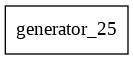

In [ ]:

# keras.utils.plot_model(D, show_shapes=True)
keras.utils.plot_model(G, show_shapes=True)

In [ ]:
class TreeGAN():
  def __init__(self, args, data):
    self.args = args
    self.G = Generator(batch_size=args.batch_size, features=args.G_FEAT, degrees=args.DEGREES, support=args.support)
    self.D = Discriminator(batch_size=args.batch_size, features=args.D_FEAT)

    self.GP = GradientPenalty(args.lambdaGP, gamma=1)
    self.data = data
    self.num_samples = self.data.shape[0]

    self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    print("Network Prepared") 

    # self.visualize = visdom.Visdom(port=args.visdom_port)
    # assert self.visualize.check_connection()
    # print("Visdom Connected")

  def run(self, save_d_ckpt=None, save_g_ckpt=None, load_g_ckpt=None, load_d_ckpt=None): # Add arguments for whether to save/load data
    # #visdom visualizations
    # color_num = self.args.visdom_color
    # chunk_size = int(self.args.point_num / color_num)
    # #color list
    # colors = np.array([(227,0,27),(231,64,28),(237,120,15),(246,176,44),
    #                        (252,234,0),(224,221,128),(142,188,40),(18,126,68),
    #                        (63,174,0),(113,169,156),(164,194,184),(51,186,216),
    #                        (0,152,206),(16,68,151),(57,64,139),(96,72,132),
    #                        (172,113,161),(202,174,199),(145,35,132),(201,47,133),
    #                        (229,0,123),(225,106,112),(163,38,42),(128,128,128)])
    # #randomly choose color from list
    # colors = colors[np.random.choice(len(colors), color_num, replace=False)]
    # label = tf.stack([tf.ones(chunk_size) * inx for inx in range(1,int(color_num)+1)], axis=0).view(-1)

    # Add option to load trained model parameters
    if not load_g_ckpt == None:
      self.G.load_weights(load_g_ckpt)
      print("Generator Checkpoint Loaded")
    if not load_d_ckpt == None:
      self.D.load_weights(load_d_ckpt)
      print("Discriminator Checkpoint Loaded")

    #training loop (for one epoch)
    for epoch in range(1):
      # for batch in range(self.args.batch_size):
      # for i in range(batch * self.args.batch_size, (batch + 1) * self.args.batch_size):
      for  i in range(self.num_samples):
        start_time = time.time()
        half_batch = int (self.args.batch_size / 2)

        # -------Discriminator------- #
        d_loss_sum = 0
        for iter in range(self.args.D_iter):
          # Generate latent vectors
          # latent = np.random.randn(self.args.latent_dim * self.args.batch_size)
          # latent = latent.reshape(self.args.batch_size, self.args.latent_dim)
          # BATCH_SIZE = 1 come back and fix
          latent = [tf.random.uniform((1,1,  1, 96))]
          # Generate fake points using Generator network
          fake_point = self.G(latent)
          if i == 1:
            print("GENERATED IMAGE ", fake_point.shape )
          # Need to get real points
          with tf.GradientTape() as tape:
            real_point = self.data[i]

            # Calculate loss on fake points (mean over a batch)
            loss_f = self.D(fake_point)
            loss_f_mean = np.mean(loss_f)
            
            # Calculate loss on real points (mean over a batch)
            loss_r = self.D(real_point)
            loss_r_mean = np.mean(loss_r)

            # Get total loss and apply gradient penalty to it

            d_loss = -loss_r_mean + loss_f_mean
            
            d_loss = d_loss + self.GP(self.D, real_point, fake_point)

            

            # Calculate gradients and backpropogate through discriminator network
            print("WEIGHTS")
            print(d_loss)
            # print(np.array(self.D.trainable_weights).shape)

          # FIX THIS ALSO G WEIGHTS

          # d_gradients = tf.GradientTape.gradient(d_loss, self.D.trainable_weights)
          d_gradients = tape.gradient(d_loss, self.D.trainable_weights)
          # d_gradients = tf.GradientTape.gradient(self.D.trainable_weights)

          self.D_optimizer.apply_gradients(zip(d_gradients, self.D.trainable_weights))
          
        # -------Generator-------- #
        # Create latent vector
        # latent = np.random.randn(self.args.latent_dim * self.args.batch_size)
        # latent = latent.reshape(self.args.batch_size, self.args.latent_dim)
        # BATCH_SIZE = 1 come back and fix
        latent = [tf.random.uniform((1,1,  1, 96))]

        # Use latent vector to generate examples
        
        
        # Calculate mean loss using discriminator
        with tf.GradientTape() as tape2:
          fake_point = self.G(latent)
          G_fake = self.D(fake_point)
          G_fake_mean = np.mean(G_fake)
          g_loss = -G_fake_mean


        # Apply gradients and backpropograte to train

          #   HERE
          print("G LOSS")
          g_loss = tf.Variable(g_loss, dtype=tf.float32)
          print("Disc watched variables: ", self.watched_variables)
          print("Gen Watched Variables: ", tape2.watched_variables)
        
        g_gradients = tape2.gradient(g_loss, self.G.trainable_weights)

        print(g_gradients)
        self.G_optimizer.apply_gradients(zip(g_gradients, self.G.trainable_weights))

model = TreeGAN(real_args(), male_30_train)
model.run()

In [ ]:
b_size = 1
# depth = 0
features = [96, 256, 256, 256, 128, 128, 128, 3]
degrees = [1, 2, 2, 2, 2, 3, 64]
support = 10
node = 1

# model = Sequential()
# model.add(TreeGCN(b_size, depth, features, degrees, 
#                                           support=support, node=node, upsample=True, activation=True))
# model.add(TreeGCN(b_size, 1, features, degrees, 
#                                         support=support, node=96, upsample=True, activation=False))

#Functional API Implementation of TreeGCN
model_inputs = keras.Input(shape=(1, 1, 96,))
outputs = TreeGCN(b_size, 0, features, degrees, support=support, node=node, upsample=True, activation=True)(model_inputs)
outputs = TreeGCN(b_size, 1, features, degrees, support=support, node=node, upsample=True, activation=True)(outputs)
outputs = TreeGCN(b_size, 2, features, degrees, support=support, node=2, upsample=True, activation=True)(outputs)
outputs = TreeGCN(b_size, 3, features, degrees, support=support, node=4, upsample=True, activation=False)(outputs)
model = keras.Model(model_inputs, outputs, name='TreeGCN')


print(model.summary())


# Make latent vector random Tensor, then put it into a list: [Tensor] so you can append to it. Input shape of the tensor should be (batch_size, 1, 96)



z = tf.random.uniform((1,1,  1, 96))
tree = [z]
print(tree)
print(np.shape(tree))
print("FINAL OUTPUT")
y = model([tree])
# print(y)
print([ele.shape for ele in y])



0
Tree INDEX:  0 0
Tensor("tree_gcn_22/strided_slice:0", shape=(1, 1, 96), dtype=float32)
PRINTING ROOT_NUM, REPEAT_NUM
1 1
Root Node
Tensor("tree_gcn_22/sequential_81/dense_104/Tensordot:0", shape=(1, 1, 256), dtype=float32)
Tensor("tree_gcn_22/Shape:0", shape=(3,), dtype=int32)
TEMP AFTER TILE
Tensor("tree_gcn_22/Tile:0", shape=(1, 1, 256), dtype=float32)
ROOT
Tensor("tree_gcn_22/add:0", shape=(1, 1, 256), dtype=float32)
W_BRANCH
<tf.Variable 'branch:0' shape=(1, 96, 96) dtype=float32>
branch shape after EXPAND DIMS Tensor("tree_gcn_22/matmul:0", shape=(1, 1, 1, 96), dtype=float32)
BRANCH AFTER RESHAPE
Tensor("tree_gcn_22/Reshape_1:0", shape=(1, 1, 96), dtype=float32)
Branch W_loop call
Tensor("tree_gcn_22/sequential_82/dense_106/Tensordot:0", shape=(1, 1, 256), dtype=float32)
BRANCH AFTER RE TILE
Tensor("tree_gcn_22/add_1:0", shape=(1, 1, 256), dtype=float32)
0
Tree INDEX:  0 1
Tensor("Placeholder:0", shape=(1, 1, 96), dtype=float32)
PRINTING ROOT_NUM, REPEAT_NUM
1 1
Root Node
Tenso

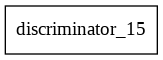

In [ ]:

keras.utils.plot_model(D, show_shapes=True)
# keras.utils.plot_model(G, show_shapes=True)

In [ ]:
# Declarations
epochs = 10
latent_dim = 96
batch_size = 1
G_FEAT = [96, 256, 256, 256, 128, 128, 128, 3]
D_FEAT = [3, 64, 128, 256, 512, 1024]
# DEGREES = [1, 2, 2, 2, 2, 2, 64]
DEGREES = [1, 2, 2, 2, 2, 3, 64] # (2^4)(3)(64) = 3072
support = 10
lambdaGP = 10
D_iter = 2



G = Generator(batch_size=batch_size, features=G_FEAT, degrees=DEGREES, support=support)
D = Discriminator(batch_size=batch_size, features=D_FEAT)

GP = GradientPenalty(lambdaGP, gamma=1)

print("Network Prepared")

def run(G, D, GP): # Add arguments for whether to save/load data
  # Add option to load trained model parameters


  #training loop (for one epoch)
  for epoch in range(epochs):
    for _iter, data in enumerate(male_30):
      # Start Time
      start_time = time.time()
      point = data
      # point = point.to(self.args.device)
    # for batch in range(batch_size):
    #   start_time = time.time()
      # half_batch = int (batch_size / 2)
      half_batch = 1

      # -------Discriminator------- #
      d_loss_sum = 0
      for iter in range(D_iter):
        latent = np.random.randn(latent_dim * half_batch)
        latent = latent.reshape(half_batch, 1, latent_dim)
        # fake_point = G.predict(latent) # will generator run through multiple point array?
        fake_point = G([latent]) # will generator run through multiple point array?

        print(f"shape fake point: {str(fake_point.shape)}")
        fake_labels = np.zeros((half_batch, 1))

        # Need to generate real samples and labels of 1
        real_labels = np.ones(1) # come back to this

        D_real = D(point)
        D_realm = D_real.mean()

        D_fake = D(fake_point)
        D_fakem = D_fake.mean()

        gp_loss = GP(D, point, fake_point)
                    
        d_loss = -D_realm + D_fakem
        d_loss_gp = d_loss + gp_loss
        d_loss_gp.backward()
          
          
          
        d_loss_sum += d_loss
      epoch_d_loss = d_loss_sum / D_iter
      print(epoch_d_loss)

run(G, D, GP)

layer num : 0
printing root network
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               24576     
Total params: 24,576
Trainable params: 24,576
Non-trainable params: 0
_________________________________________________________________
None
printing loop network
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 960)               92160     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               245760    
Total params: 337,920
Trainable params: 337,920
Non-trainable params: 0
_________________________________________________________________
None
layer num : 1
printing root network
Model: "sequential_9"
____________________________

NameError: ignored

In [ ]:
t1 = tf.ragged.constant([1, 2, 3, 4])
t15 = tf.ragged.constant([5, 6, 7, 8])
t2 = tf.ragged.constant([5, 6, 7])
rslt = tf.ragged.stack([t1, t2], axis=0)
rslt2 = tf.concat([t1, t2], axis=0)
print("Append")
print(tf.append(t1, t2))
print("Stack:")
print(rslt)
print(rslt.shape)
print("\n\nConcat:")
print(rslt2)
print(rslt2.shape)

Append


AttributeError: ignored

In [ ]:
root_node = np.random.rand(1,96)
np.tile(root_node,(1,1, 0,))


array([], shape=(1, 1, 0), dtype=float64)

In [ ]:
batch_size = 1
z = torch.randn(batch_size, 1, 96)
z

tensor([[[-0.8733, -0.0546,  2.2709,  0.0183,  0.9948, -0.2578, -0.0441,
           0.4027, -0.7995, -0.7677, -1.3520,  1.0531,  0.8074,  0.0935,
           0.8771, -0.3280, -0.3718,  0.8556,  0.9983,  1.4913, -0.2695,
          -0.6800, -1.0328,  0.9548,  0.3431,  2.1092, -0.7956,  1.8980,
           0.6018,  1.4046, -1.6744, -0.8126, -0.5736, -1.2721, -0.9579,
           0.8323, -0.4504, -0.7566,  0.4937, -0.9049, -0.8361,  2.0934,
          -1.0041,  0.9372, -0.0170,  1.0036, -0.9464,  1.1170, -0.6734,
           1.7174, -1.0596, -0.5771, -1.7171,  0.5099,  0.9728,  1.9991,
           1.1616, -2.5841, -1.2355, -0.0977,  0.9207,  1.5323, -3.2910,
          -0.4647,  0.9143, -0.2745, -0.2522,  0.5150,  1.1296, -0.6209,
          -0.3460, -0.5545, -0.1199,  1.2911,  1.0014,  1.5679, -1.0336,
           0.1151,  0.4952,  0.6442, -1.0836,  0.0331, -0.4824,  0.3427,
          -0.5273, -0.0797, -0.2759, -1.0274, -0.5612, -1.2850,  0.5042,
           0.3359, -0.1767, -0.5021,  0.8841, -0.39

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import math
from torchsummary import summary

class TreeGCN2(nn.Module):
    def __init__(self, batch, depth, features, degrees, support=10, node=1, upsample=False, activation=True):
        self.batch = batch
        self.depth = depth
        self.in_feature = features[depth]
        self.out_feature = features[depth+1]
        self.node = node
        self.degree = degrees[depth]
        self.upsample = upsample
        self.activation = activation
        super(TreeGCN2, self).__init__()

        self.W_root = nn.ModuleList([nn.Linear(features[inx], self.out_feature, bias=False) for inx in range(self.depth+1)])

      
        if self.upsample:
            self.W_branch = nn.Parameter(torch.FloatTensor(self.node, self.in_feature, self.degree*self.in_feature))
        
        self.W_loop = nn.Sequential(nn.Linear(self.in_feature, self.in_feature*support, bias=False),
                                    nn.Linear(self.in_feature*support, self.out_feature, bias=False))

        self.bias = nn.Parameter(torch.FloatTensor(1, self.degree, self.out_feature))

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

        self.init_param()

    def init_param(self):
        if self.upsample:
            init.xavier_uniform_(self.W_branch.data, gain=init.calculate_gain('relu'))

        stdv = 1. / math.sqrt(self.out_feature)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, tree):
        root = 0
        for inx in range(self.depth+1):
            print("Tree Index: ", inx)
            root_num = tree[inx].size(1)
            repeat_num = int(self.node / root_num)
            root_node = self.W_root[inx](tree[inx])
            
            print("W_Root " * 5)
            print(root_node)
            print(root_node.size())
            root = root + root_node.repeat(1,1,repeat_num).view(self.batch,-1,self.out_feature)

        branch = 0
        if self.upsample:
            # print("BRANCH BEFORE: ", self.W_branch, self.W_branch.size())
            print(self.W_branch)
            branch = tree[-1].unsqueeze(2) @ self.W_branch
            print("BRANCH AFTER EXPAND DIMS: ", branch)
            branch = self.leaky_relu(branch)
            branch = branch.view(self.batch,self.node*self.degree,self.in_feature)
            print("BRANCH AFTER RESHAPE")
            print(branch)
            branch = self.W_loop(branch)
            print("BRANCH AFTER W_LOOP")
            print(branch)

            branch = root.repeat(1,1,self.degree).view(self.batch,-1,self.out_feature) + branch
            print("BRANCH AFTER RE-TILE")
            print(branch)
        else:
            branch = self.W_loop(tree[-1])

            branch = root + branch

        if self.activation:
            branch = self.leaky_relu(branch + self.bias.repeat(1,self.node,1))
        # print("BRANCH: ", branch)
        # print(branch.size())
        tree.append(branch)
        print("TREE: ", tree)
        # print(tree[self.degree].size(2))

        return tree

In [ ]:
import torch
e = torch.Tensor(np.random.rand(96,1)).size(1)
print(e)
torch.Tensor(np.random.rand(1,256)).repeat(1,1,e)

1


tensor([[[8.8406e-01, 1.9698e-01, 6.4448e-01, 7.6747e-02, 1.1835e-01,
          7.1322e-01, 5.2173e-01, 2.2455e-01, 1.1613e-01, 6.1025e-01,
          9.0531e-01, 6.1741e-01, 4.4902e-01, 1.0194e-01, 8.4654e-01,
          3.7144e-02, 3.9426e-01, 2.9562e-01, 4.8583e-01, 2.6039e-01,
          2.5511e-01, 7.2638e-02, 1.0020e-01, 1.1377e-01, 2.4851e-01,
          6.3778e-01, 9.8248e-01, 4.2398e-01, 3.4107e-01, 9.0604e-01,
          6.1468e-01, 9.3168e-01, 5.7363e-01, 1.0410e-01, 5.7699e-01,
          2.5268e-01, 7.8311e-01, 3.1477e-02, 1.2948e-01, 2.8539e-01,
          7.5978e-01, 2.0567e-01, 4.0710e-01, 1.7996e-01, 3.5197e-01,
          4.3026e-01, 6.1660e-01, 3.4781e-01, 6.6200e-02, 3.1306e-01,
          6.0058e-01, 5.4066e-01, 9.5578e-01, 4.3579e-01, 7.3190e-01,
          5.9338e-01, 4.2013e-01, 5.9922e-01, 6.8946e-01, 4.6765e-01,
          1.0542e-01, 6.7928e-01, 2.9240e-01, 1.2834e-01, 8.7227e-01,
          1.6970e-01, 2.2152e-01, 1.1495e-02, 8.5221e-01, 1.6846e-01,
          7.8849e-01

In [ ]:
b_size = 1
depth = 0
features = [96, 256, 256, 256, 128, 128, 128, 3]
degrees = [1, 2, 2, 2, 2, 3, 64]
support = 10
node = 1

model = nn.Sequential()
model.add_module('TreeGCN_1', TreeGCN2(b_size, depth, features, degrees, 
                                          support=support, node=node, upsample=True, activation=True))
model.add_module('TreeGCN_2', TreeGCN2(b_size, 1, features, degrees, 
                                        support=support, node=96, upsample=True, activation=False))

z = torch.randn(1, 1, 96).to('cpu')

tree = [z]
print(tree)

rslt = model(tree)
# print(rslt[2].size())


[tensor([[[-0.5592,  0.7195,  0.0902, -0.7645,  0.5009,  0.9356,  1.1576,
           0.0895,  0.0499,  1.3580,  0.9120,  0.1221, -1.2000,  0.2125,
          -0.6897,  1.3398, -0.2230, -0.1560,  1.1665, -2.5133,  0.3422,
           2.0728,  0.0940, -0.5081,  0.7896,  0.7702, -2.9093, -0.8321,
          -0.0458, -0.3320,  1.3263,  0.1174, -2.0827,  1.2304, -1.6795,
          -0.2438,  1.4297, -1.4262, -1.2684, -1.4513,  0.9206,  0.2446,
           1.7557, -0.3561, -1.1258, -0.6415, -1.8889,  1.5338,  2.2119,
          -0.0136,  1.5002, -0.8671, -0.1292, -0.3307,  1.2108, -0.7479,
          -1.8422, -1.0137,  2.4267,  0.7600,  2.0832, -1.7096,  1.8181,
          -1.8974,  2.6776, -1.3456, -0.9727, -1.4971,  0.1858,  0.1951,
          -1.1137, -0.8314,  1.2338,  0.0291,  1.0746, -0.3362, -1.2208,
           1.2026, -1.2525,  1.8656,  1.0375,  0.1856,  1.9435,  0.8650,
           0.3755,  1.3335, -0.6190, -0.6345,  0.0618, -0.0166,  0.4907,
          -1.2111, -0.1377,  1.4718,  0.3810, -0.2

In [ ]:
from keras.layers import *
from keras.models import *
import numpy as np

class Lay(Layer):
    def init(self):
        super(Lay,self).__init__()

    def build(self, inputShape):
        super(Lay,self).build(inputShape)

    def call(self,x):
        return [x[0],x[-1]]

    def compute_output_shape(self,inputShape):
        return [(None,1),(None,1)]


inp = Input((2,))
out = Lay()(inp)
print(type(out))
# out = Concatenate()(out)
out = Lay()(out)

new = Lay(out)
# final = Concatenate()(new)

model = Model(inp,out)
model.summary()

data = [[1,2],[3,4],[5,6]]
print(model.predict(data))

import keras
print(keras.__version__)

<class 'list'>
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
lay_30 (Lay)                    [(2,), (2,)]         0           input_34[0][0]                   
__________________________________________________________________________________________________
lay_31 (Lay)                    [(2,), (2,)]         0           lay_30[0][0]                     
                                                                 lay_30[0][1]                     
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________
[array([1., 2.],